<img src="https://www.shutterstock.com/image-illustration/blue-money-business-graph-finance-600nw-2166540277.jpg" alt="Business Graph" title="Business Graph" width="100%">

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image, display
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Exploration and Cleaning:

In [2]:
# Load the CSV files
clients_df = pd.read_csv('Desktop/Clients.csv')
clients_df.head()

,client_id,entity_type,entity_year_established
0,786,Australian Private Company,2002
1,230,Australian Private Company,2008
2,282,Individual/Sole Trader,2001
3,447,Australian Private Company,2013
4,310,Individual/Sole Trader,2015


In [3]:
payments_df = pd.read_csv('Desktop/Payments.csv')
payments_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
0,20175,927,1,1527012511,66.66,PAYMENT
1,8485,927,1,1511716095,66.66,PAYMENT
2,13778,927,1,1519319303,66.66,PAYMENT
3,22768,927,1,1529863724,66.66,PAYMENT
4,15698,927,1,1521738504,66.66,PAYMENT


In [4]:
# Convert the EPOCH format transaction_date to datetime
payments_df['transaction_date'] = pd.to_datetime(payments_df['transaction_date'], unit='s')

In [5]:
# Check for missing values in both datasets
clients_missing = clients_df.isnull().sum()
payments_missing = payments_df.isnull().sum()

In [6]:
# Display the first few rows of each dataframe
clients_df.head()

,client_id,entity_type,entity_year_established
0,786,Australian Private Company,2002
1,230,Australian Private Company,2008
2,282,Individual/Sole Trader,2001
3,447,Australian Private Company,2013
4,310,Individual/Sole Trader,2015


In [7]:
payments_df.head()

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code
0,20175,927,1,2018-05-22 18:08:31,66.66,PAYMENT
1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT
2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT
3,22768,927,1,2018-06-24 18:08:44,66.66,PAYMENT
4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT


In [8]:
clients_df.shape

(1287, 3)

In [9]:
payments_df.shape

(25559, 6)

In [10]:
# Checking for any missing values for Payments dataset 
payments_df.isna().sum()

transaction_id      0
contract_id         0
client_id           0
transaction_date    0
payment_amt         0
payment_code        0
dtype: int64

In [11]:
# Checking for any missing values for Clients dataset
clients_df.isna().sum()

client_id                  0
entity_type                0
entity_year_established    0
dtype: int64

## Data Analysis

### Analyze the Distribution of Payment Amounts and Defaults

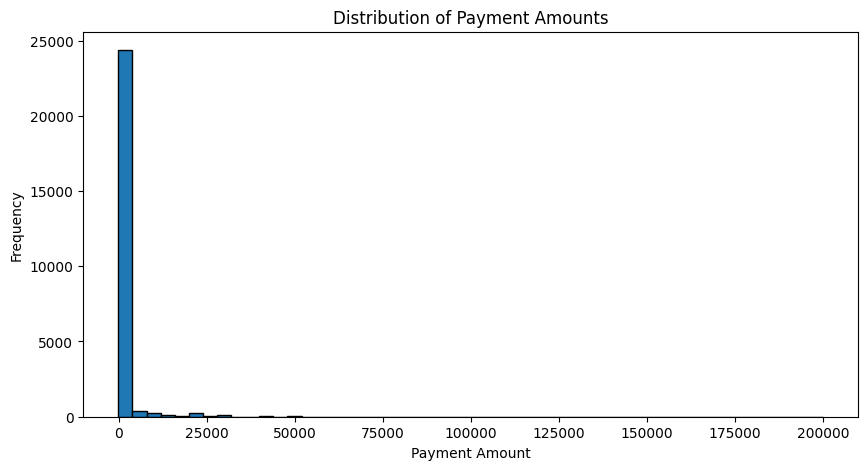

In [12]:
# Distribution of payment amounts
plt.figure(figsize=(10, 5))
plt.hist(payments_df['payment_amt'], bins=50, edgecolor='k')
plt.title('Distribution of Payment Amounts')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.show()

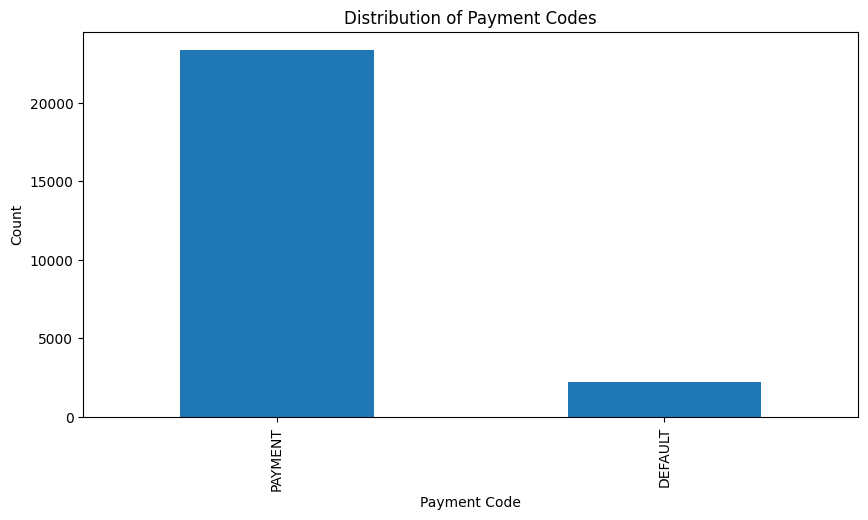

In [13]:
# Distribution of payment codes
payment_code_counts = payments_df['payment_code'].value_counts()
plt.figure(figsize=(10, 5))
payment_code_counts.plot(kind='bar')
plt.title('Distribution of Payment Codes')
plt.xlabel('Payment Code')
plt.ylabel('Count')
plt.show()

In [14]:
print("Payment Code Counts:")
print(payment_code_counts)

Payment Code Counts:
PAYMENT    23340
DEFAULT     2219
Name: payment_code, dtype: int64


## Descriptive Statistics and Visualizations:

### Explore Client Characteristics and Their Relationship with Payment Defaults:

In [15]:
# Merge clients_df and payments_df on client_id
merged_df = pd.merge(payments_df, clients_df, on='client_id')

In [16]:
merged_df.head(5)

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
0,20175,927,1,2018-05-22 18:08:31,66.66,PAYMENT,Other Partnership,2006
1,8485,927,1,2017-11-26 17:08:15,66.66,PAYMENT,Other Partnership,2006
2,13778,927,1,2018-02-22 17:08:23,66.66,PAYMENT,Other Partnership,2006
3,22768,927,1,2018-06-24 18:08:44,66.66,PAYMENT,Other Partnership,2006
4,15698,927,1,2018-03-22 17:08:24,66.66,PAYMENT,Other Partnership,2006


In [17]:
merged_df.tail(5)

,transaction_id,contract_id,client_id,transaction_date,payment_amt,payment_code,entity_type,entity_year_established
25849,25075,1603,1280,2018-07-19 18:09:24,1666.68,PAYMENT,Australian Private Company,2016
25850,24711,1603,1280,2018-07-16 18:09:20,0.01,PAYMENT,Australian Private Company,2016
25851,25076,1603,1280,2018-07-19 18:09:24,64.99,PAYMENT,Australian Private Company,2016
25852,25132,1627,1281,2018-07-22 18:08:06,0.01,PAYMENT,Australian Private Company,2012
25853,25131,1627,1281,2018-07-22 18:08:06,20000.05,PAYMENT,Australian Private Company,2012


In [18]:
merged_df.describe()

,transaction_id,contract_id,client_id,payment_amt,entity_year_established
count,25854.000000,25854.000000,25854.000000,25854.000000,25854.000000
mean,12781.997138,758.568384,602.831477,1225.552848,2009.150576
std,7383.715669,352.121377,343.589521,4343.666629,5.616094
min,1.000000,1.000000,1.000000,-136.660000,1999.000000
25%,6388.250000,510.000000,309.000000,93.330000,2005.000000
50%,12782.500000,730.000000,591.000000,266.660000,2011.000000
75%,19181.750000,992.000000,891.000000,833.330000,2014.000000
max,25559.000000,1643.000000,1281.000000,200000.050000,2018.000000


In [19]:
merged_df.corr()

,transaction_id,contract_id,client_id,payment_amt,entity_year_established
transaction_id,1.000000,0.703941,0.110636,0.079157,0.009555
contract_id,0.703941,1.000000,0.152465,0.220913,0.023018
client_id,0.110636,0.152465,1.000000,0.057585,0.056237
payment_amt,0.079157,0.220913,0.057585,1.000000,-0.022515
entity_year_established,0.009555,0.023018,0.056237,-0.022515,1.000000


In [20]:
print(merged_df['payment_code'].value_counts())

PAYMENT    23618
DEFAULT     2236
Name: payment_code, dtype: int64


In [21]:
print(merged_df['entity_type'].value_counts())

Australian Private Company        15058
Individual/Sole Trader             9418
Family Partnership                  736
Discretionary Trading Trust         187
Other Partnership                   135
Australian Public Company           128
Discretionary Investment Trust      124
Fixed Unit Trust                     32
Hybrid Trust                         32
Australian Proprietary Company        4
Name: entity_type, dtype: int64


In [22]:
print(merged_df['entity_type'].value_counts())

Australian Private Company        15058
Individual/Sole Trader             9418
Family Partnership                  736
Discretionary Trading Trust         187
Other Partnership                   135
Australian Public Company           128
Discretionary Investment Trust      124
Fixed Unit Trust                     32
Hybrid Trust                         32
Australian Proprietary Company        4
Name: entity_type, dtype: int64


In [23]:
# Checking if there are any missing values
merged_df.isna().sum()

transaction_id             0
contract_id                0
client_id                  0
transaction_date           0
payment_amt                0
payment_code               0
entity_type                0
entity_year_established    0
dtype: int64

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25854 entries, 0 to 25853
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           25854 non-null  int64         
 1   contract_id              25854 non-null  int64         
 2   client_id                25854 non-null  int64         
 3   transaction_date         25854 non-null  datetime64[ns]
 4   payment_amt              25854 non-null  float64       
 5   payment_code             25854 non-null  object        
 6   entity_type              25854 non-null  object        
 7   entity_year_established  25854 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 1.8+ MB


In [25]:
# Distribution of entity types
entity_type_counts = merged_df['entity_type'].value_counts()

In [26]:
# Calculate default rates for each entity type
default_rates = merged_df.groupby('entity_type')['payment_code'].apply(lambda x: (x == 'DEFAULT').mean())

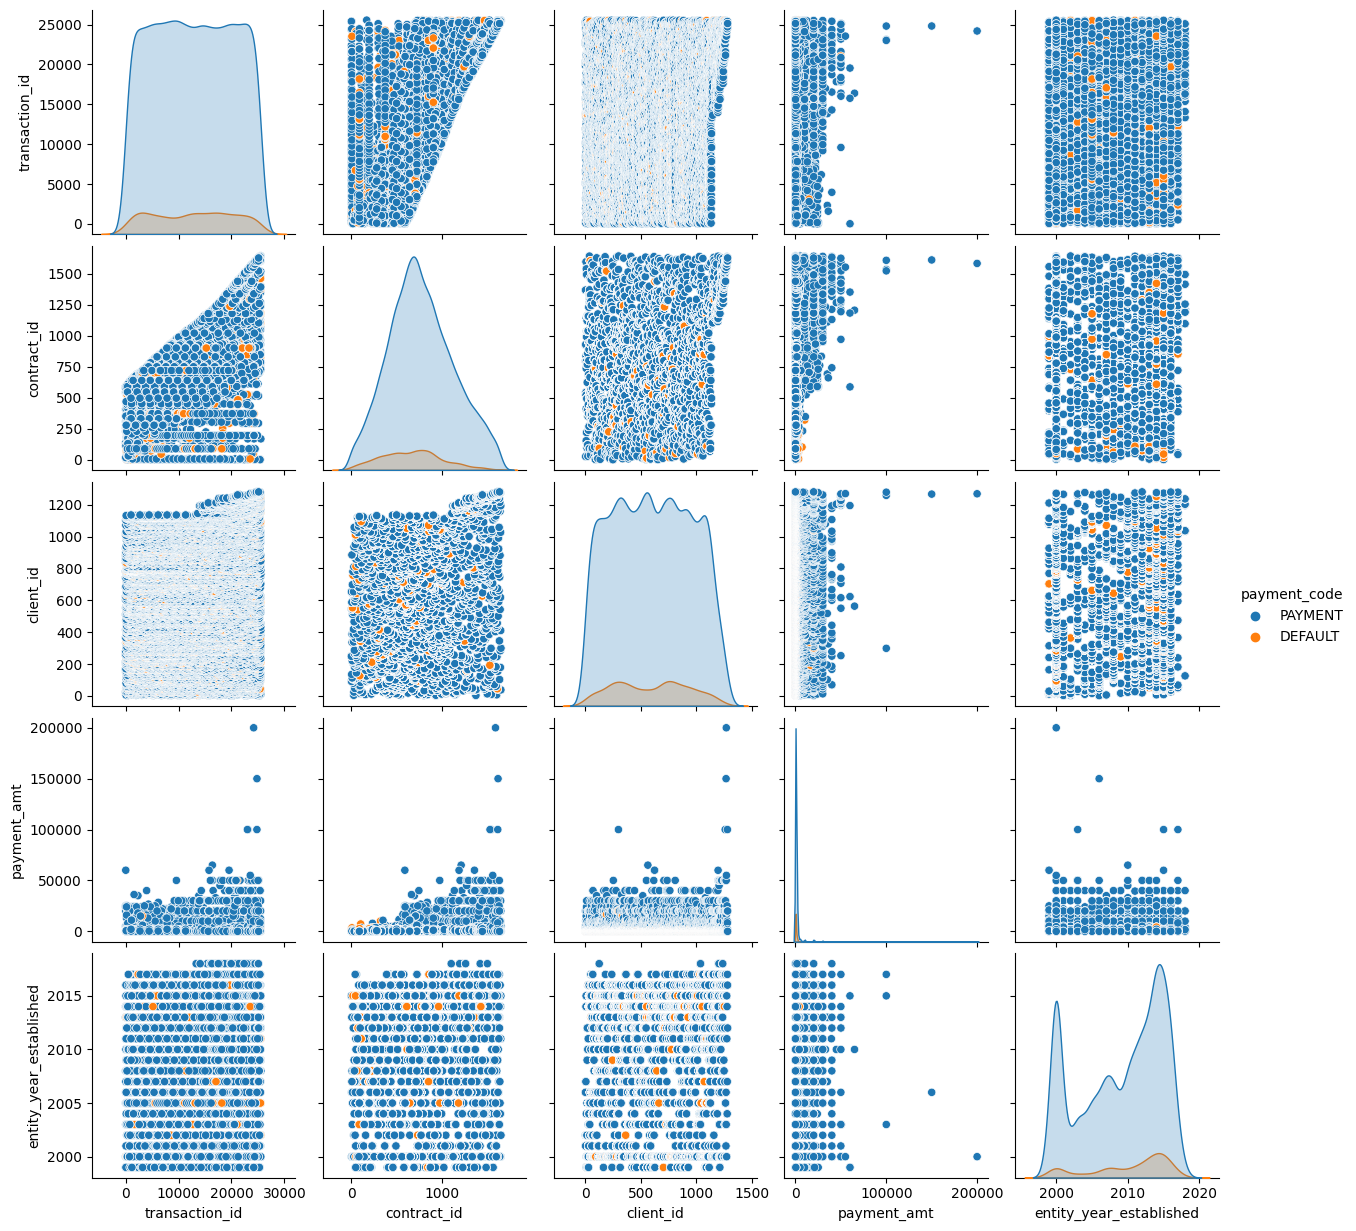

In [27]:
sns.pairplot(merged_df, hue="payment_code")

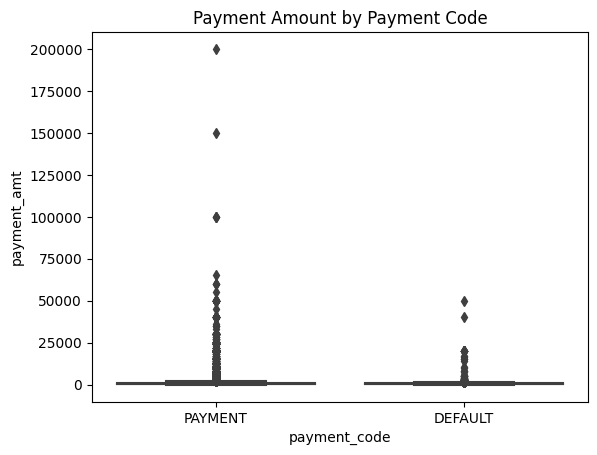

In [28]:
sns.boxplot(data=merged_df, x="payment_code", y="payment_amt")
plt.title("Payment Amount by Payment Code")
plt.show()

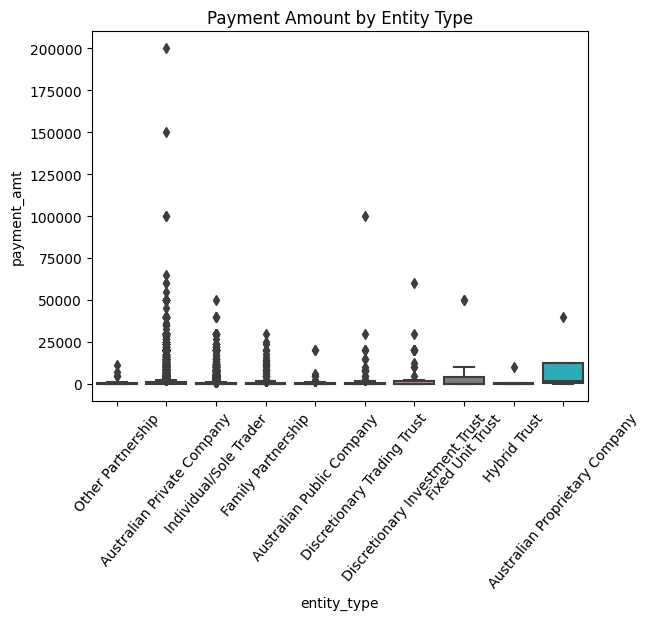

In [29]:
sns.boxplot(data=merged_df, x="entity_type", y="payment_amt")
plt.title("Payment Amount by Entity Type")
plt.xticks(rotation=50)
plt.show()

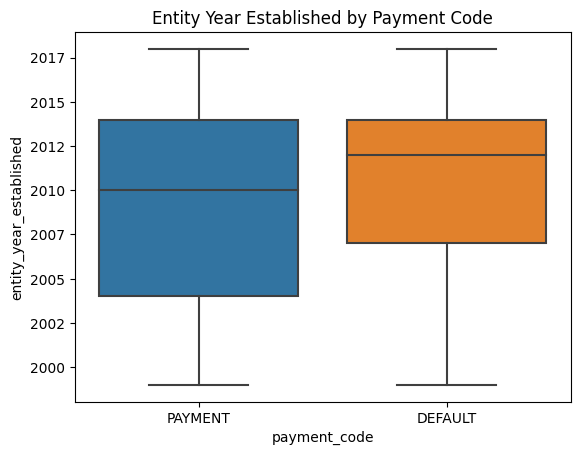

In [30]:
sns.boxplot(data=merged_df, x="payment_code", y="entity_year_established")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
plt.title("Entity Year Established by Payment Code")
plt.show()

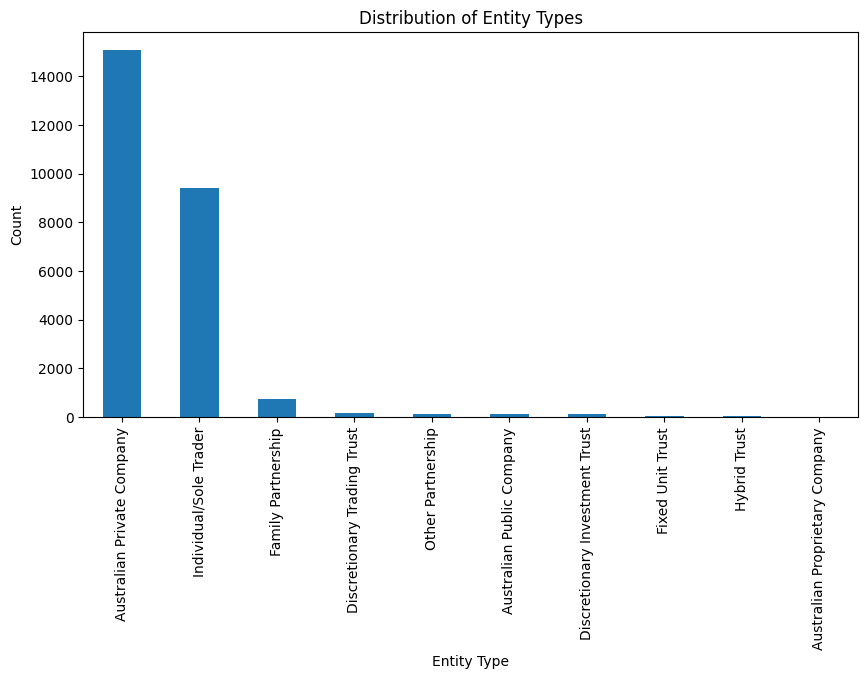

In [31]:
plt.figure(figsize=(10, 5))
entity_type_counts.plot(kind='bar')
plt.title('Distribution of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

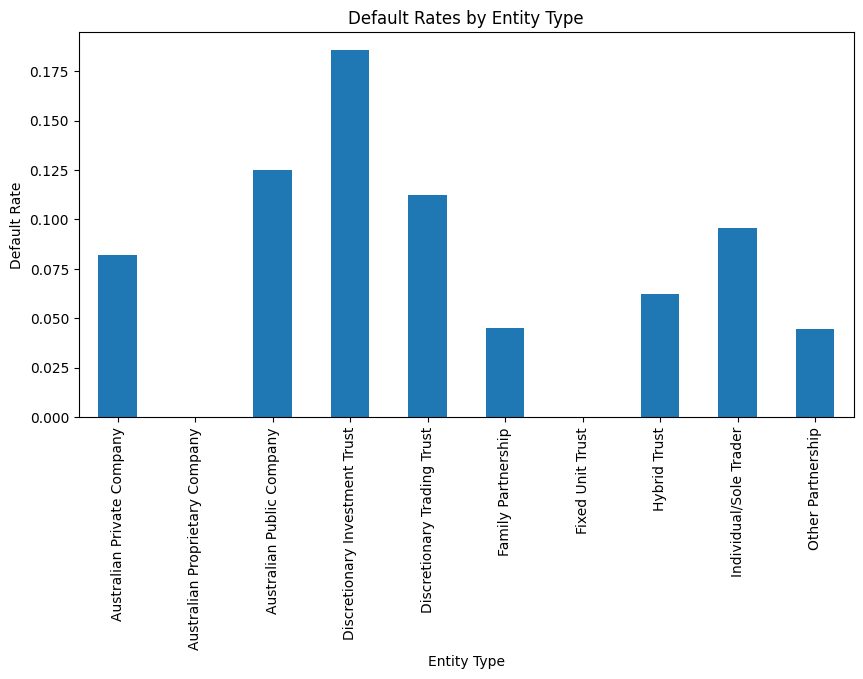

In [32]:
plt.figure(figsize=(10, 5))
default_rates.plot(kind='bar')
plt.title('Default Rates by Entity Type')
plt.xlabel('Entity Type')
plt.ylabel('Default Rate')
plt.show()

In [33]:
print("Entity Type Counts:")
print(entity_type_counts)

Entity Type Counts:
Australian Private Company        15058
Individual/Sole Trader             9418
Family Partnership                  736
Discretionary Trading Trust         187
Other Partnership                   135
Australian Public Company           128
Discretionary Investment Trust      124
Fixed Unit Trust                     32
Hybrid Trust                         32
Australian Proprietary Company        4
Name: entity_type, dtype: int64


In [34]:
print("Default Rates by Entity Type:")
print(default_rates)

Default Rates by Entity Type:
entity_type
Australian Private Company        0.081950
Australian Proprietary Company    0.000000
Australian Public Company         0.125000
Discretionary Investment Trust    0.185484
Discretionary Trading Trust       0.112299
Family Partnership                0.044837
Fixed Unit Trust                  0.000000
Hybrid Trust                      0.062500
Individual/Sole Trader            0.095668
Other Partnership                 0.044444
Name: payment_code, dtype: float64


## Calculate Business Age and Analyze Defaults:

In [35]:
# Calculate the current year
current_year = datetime.now().year

In [36]:
# Calculate the age of each business
merged_df['business_age'] = current_year - merged_df['entity_year_established']

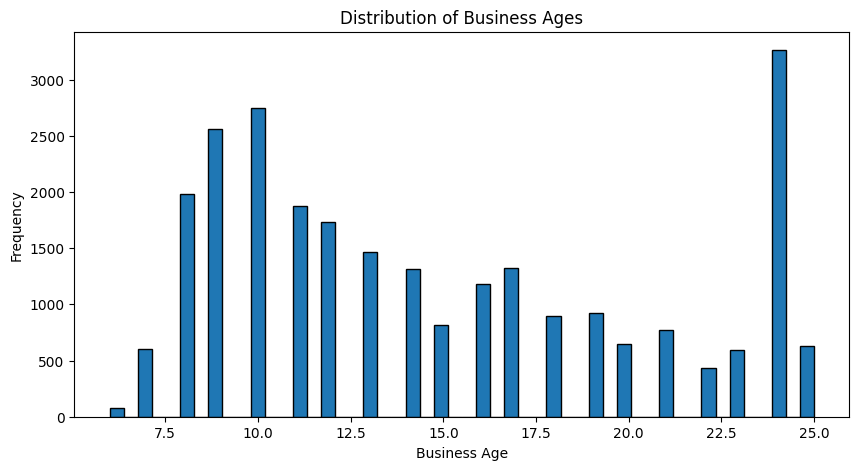

In [37]:
# Distribution of business ages
plt.figure(figsize=(10, 5))
plt.hist(merged_df['business_age'], bins=50, edgecolor='k')
plt.title('Distribution of Business Ages')
plt.xlabel('Business Age')
plt.ylabel('Frequency')
plt.show()

In [38]:
# Calculate default rates by business age
age_bins = pd.cut(merged_df['business_age'], bins=[0, 5, 10, 20, 30, 50, 100])
default_rates_by_age = merged_df.groupby(age_bins)['payment_code'].apply(lambda x: (x == 'DEFAULT').mean())

In [39]:
# Replace NaN values with zero in default rates
default_rates_by_age = default_rates_by_age.fillna(0)

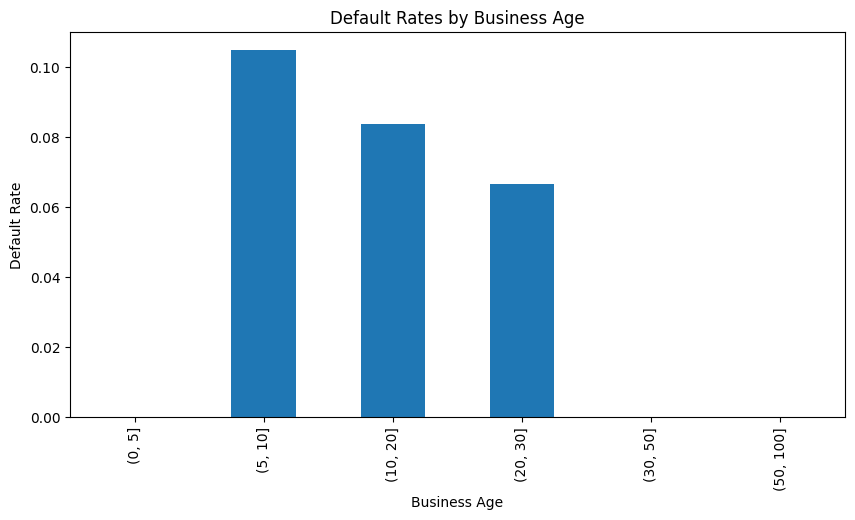

In [40]:
# Plot the default rates by business age
plt.figure(figsize=(10, 5))
default_rates_by_age.plot(kind='bar')
plt.title('Default Rates by Business Age')
plt.xlabel('Business Age')
plt.ylabel('Default Rate')
plt.show()

In [41]:
print("Default Rates by Business Age:")
print(default_rates_by_age)

Default Rates by Business Age:
business_age
(0, 5]       0.000000
(5, 10]      0.104715
(10, 20]     0.083826
(20, 30]     0.066667
(30, 50]     0.000000
(50, 100]    0.000000
Name: payment_code, dtype: float64


## Feature Engineering and Data Scaling:

In [42]:
# Create features: total_payments and default_count
# These features should help capture the client's payment behavior
client_payment_stats = merged_df.groupby('client_id').agg(
    total_payments=('payment_code', 'count'),
    default_count=('payment_code', lambda x: (x == 'DEFAULT').sum())
).reset_index()

In [43]:
# Merge features back into the main dataframe
features_df = pd.merge(merged_df, client_payment_stats, on='client_id')

In [44]:
# Select relevant columns for modeling
# Focus on key attributes that could influence default rates
features_df = features_df[['client_id', 'entity_type', 'business_age', 'payment_amt', 'total_payments', 
                           'default_count', 'payment_code']]

In [45]:
# Convert entity_type to numerical using one-hot encoding
features_df = pd.get_dummies(features_df, columns=['entity_type'], drop_first=True)

In [46]:
# Define the target variable
features_df['is_default'] = features_df['payment_code'].apply(lambda x: 1 if x == 'DEFAULT' else 0)

In [47]:
# Drop the original payment_code column
features_df.drop(columns=['payment_code'], inplace=True)

In [48]:
# Display the first few rows of the features dataframe
print("Features Data:")
features_df.head()

Features Data:


,client_id,business_age,payment_amt,total_payments,default_count,entity_type_Australian Proprietary Company,entity_type_Australian Public Company,entity_type_Discretionary Investment Trust,entity_type_Discretionary Trading Trust,entity_type_Family Partnership,entity_type_Fixed Unit Trust,entity_type_Hybrid Trust,entity_type_Individual/Sole Trader,entity_type_Other Partnership,is_default
0,1,18,66.66,18,0,0,0,0,0,0,0,0,0,1,0
1,1,18,66.66,18,0,0,0,0,0,0,0,0,0,1,0
2,1,18,66.66,18,0,0,0,0,0,0,0,0,0,1,0
3,1,18,66.66,18,0,0,0,0,0,0,0,0,0,1,0
4,1,18,66.66,18,0,0,0,0,0,0,0,0,0,1,0


## Model Building and Evaluation:

In [49]:
# Define feature matrix and target vector
X = features_df.drop(columns=['client_id', 'is_default'])
y = features_df['is_default']

In [50]:
# Train-test split
# Using a stratified split to ensure the target variable is evenly distributed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [51]:
print("Training Set Shapes:")
X_train.shape

Training Set Shapes:


(19390, 13)

In [52]:
print("Testing Set Shapes:")

Testing Set Shapes:


In [53]:
X_test.shape

(6464, 13)

## Handle Class Imbalance:

In [54]:
# Handle class imbalance with oversampling
# This step ensures we have enough examples of the minority class
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]
minority_class_oversampled = minority_class.sample(len(majority_class), replace=True, random_state=42)
X_train_resampled = pd.concat([majority_class, minority_class_oversampled])
y_train_resampled = pd.concat([y_train[y_train == 0], y_train[y_train == 1].sample
                               (len(majority_class), replace=True, random_state=42)])

In [55]:
print("Resampled Training Set Shapes:")
print(X_train_resampled.shape, y_train_resampled.shape)

Resampled Training Set Shapes:
(35426, 13) (35426,)


## Train and Evaluate the Gradient Boosting Model:

In [56]:
# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

In [57]:
# Train the model on the resampled training data
gb_model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [58]:
# Predict on test data
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

In [59]:
# Evaluate model accuracy
accuracy_gb = gb_model.score(X_test, y_test)*100
print(f"Model Accuracy: {accuracy_gb:.2f}%")

Model Accuracy: 74.72%


In [60]:
# Evaluate the model's performance
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

In [61]:
print("Confusion Matrix:")
conf_matrix_gb

Confusion Matrix:


array([[4333, 1572],
       [  62,  497]])

In [62]:
# Detailed classification report
class_report_gb = classification_report(y_test, y_pred_gb)
print("Classification Report:")
print(class_report_gb)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      5905
           1       0.24      0.89      0.38       559

    accuracy                           0.75      6464
   macro avg       0.61      0.81      0.61      6464
weighted avg       0.92      0.75      0.80      6464



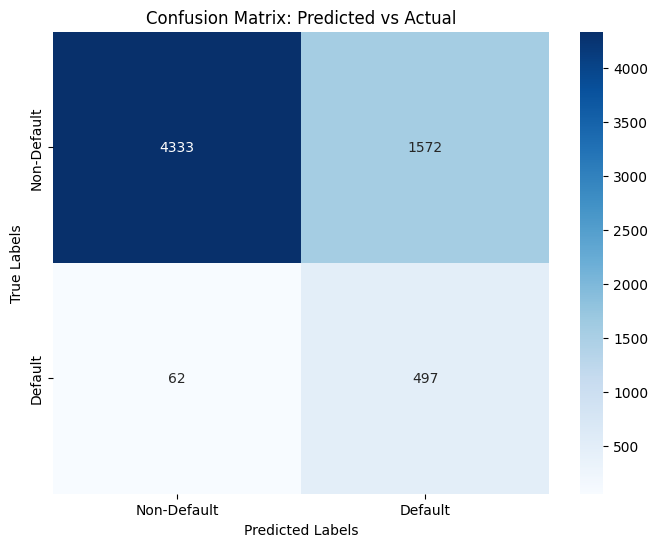

In [63]:
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], 
            yticklabels=['Non-Default', 'Default'])
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

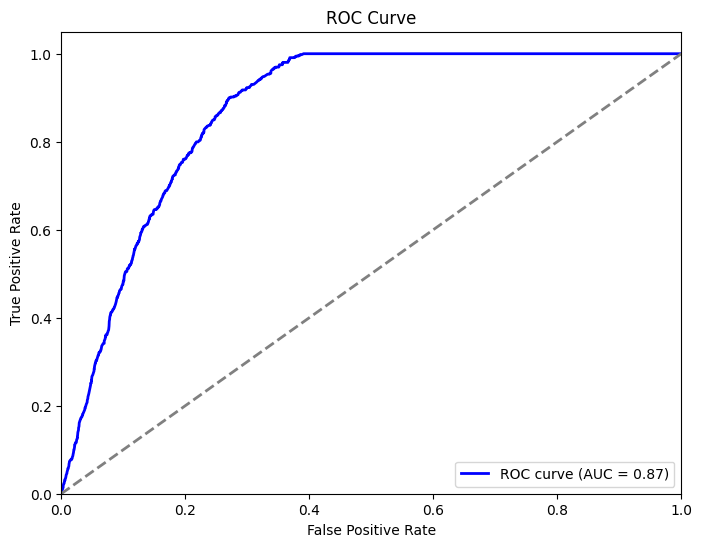

In [64]:
fpr, tpr, _ = roc_curve(y_test, y_prob_gb)
roc_auc = roc_auc_score(y_test, y_prob_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Hyperparameters for tuning:

In [65]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=10, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

best_params = grid_search.best_params_
gb_optimized = GradientBoostingClassifier(**best_params)
gb_optimized.fit(X_train, y_train)

accuracy = gb_optimized.score(X_test, y_test)
print(f"Optimized model accuracy: {accuracy:.2f}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy found:  0.9140278436303323
Optimized model accuracy: 0.91


In [66]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'subsample': [1.0]
}

In [67]:
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.sample(frac=0.1, random_state=42, axis=0)

if len(X_train_sample.shape) == 1:
    X_train_sample = X_train_sample.reshape(-1, 1)
if len(y_train_sample.shape) != 1:
    y_train_sample = y_train_sample.ravel()

try:
    grid_search.fit(X_train_sample, y_train_sample)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best accuracy found: ", grid_search.best_score_)

    best_params = grid_search.best_params_
    gb_optimized = GradientBoostingClassifier(**best_params)
    gb_optimized.fit(X_train_sample, y_train_sample)

    accuracy = gb_optimized.score(X_test, y_test)
    print(f"Optimized model accuracy: {accuracy:.2f}")
except ValueError as e:
    print("Error during model fitting:", e)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy found:  0.9252196770679313
Optimized model accuracy: 0.91


In [68]:
param_dist = {
    'n_estimators': randint(100, 200),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 4),
    'min_samples_split': randint(2, 5),
    'min_samples_leaf': randint(1, 2),
    'subsample': uniform(0.8, 1.0)
}

random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist, 
                                   n_iter=50, cv=3, n_jobs=-1, verbose=10, scoring='accuracy')
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)

best_params = random_search.best_params_
gb_optimized = GradientBoostingClassifier(**best_params)
gb_optimized.fit(X_train, y_train)

accuracy = gb_optimized.score(X_test, y_test)
print(f"Optimized model accuracy: {accuracy:.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'learning_rate': 0.04929519015893816, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 101, 'subsample': 0.8760636275237871}
Best accuracy found:  0.9140794352238103
Optimized model accuracy: 0.91


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5905
           1       0.29      0.00      0.01       559

    accuracy                           0.91      6464
   macro avg       0.60      0.50      0.48      6464
weighted avg       0.86      0.91      0.87      6464



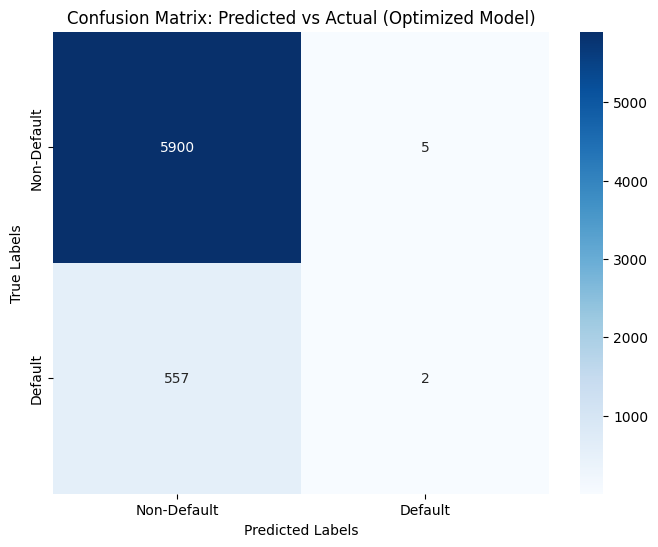

In [69]:
y_pred = gb_optimized.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Predicted vs Actual (Optimized Model)')
plt.show()

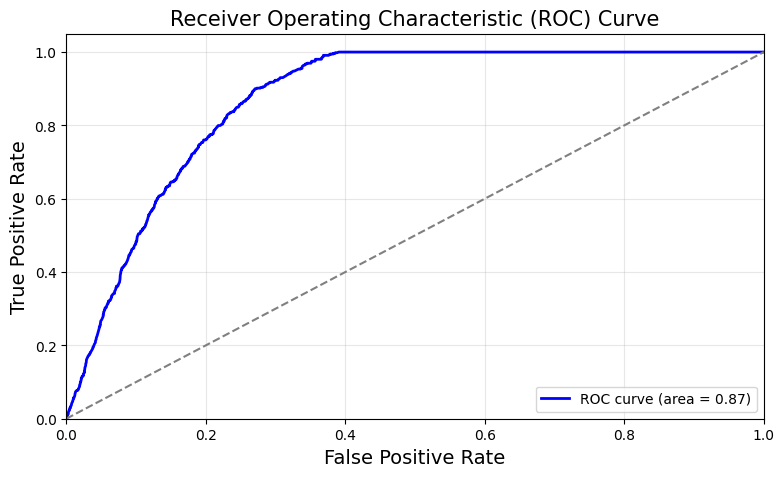

In [70]:
plt.figure(figsize=(9, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Feature Importance

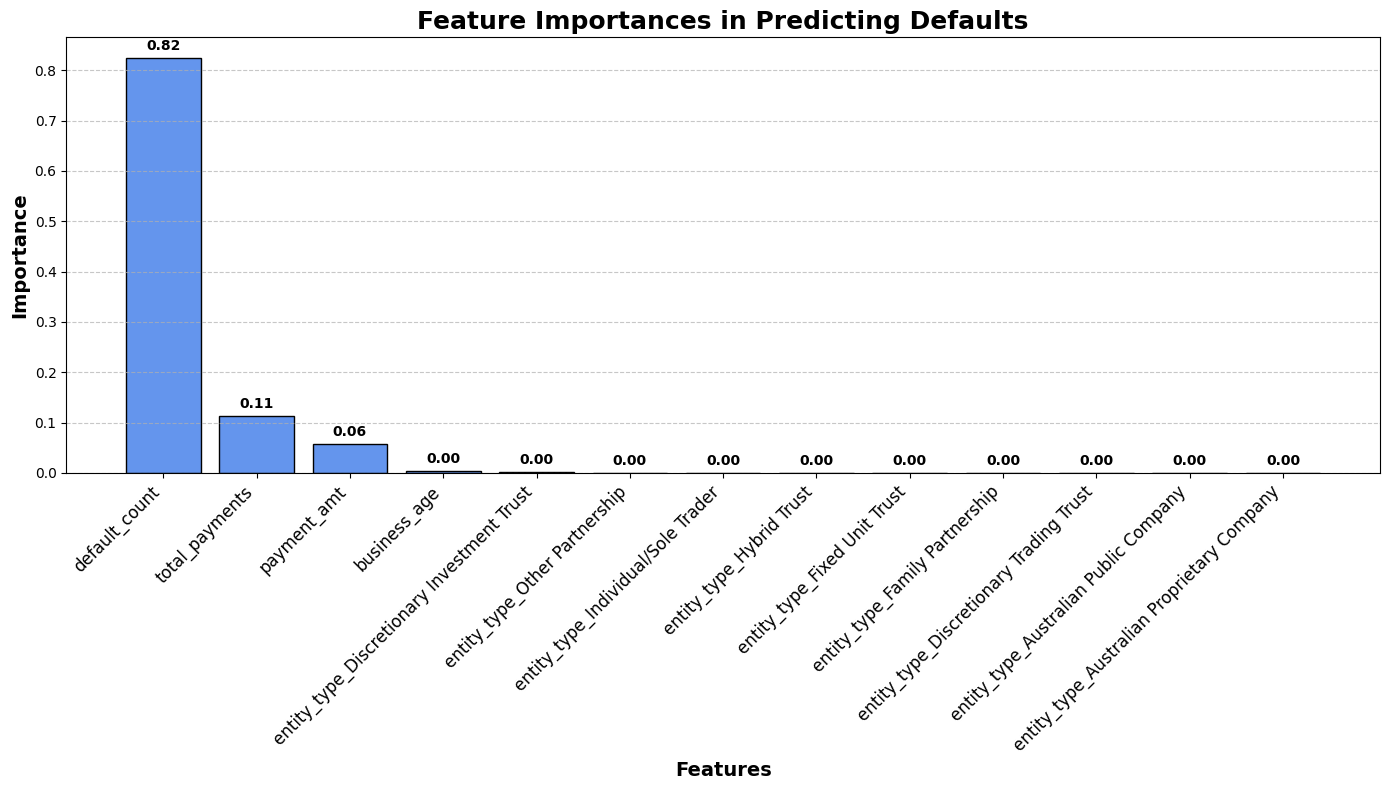

In [71]:
importances = gb_optimized.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(14, 8))
plt.title("Feature Importances in Predicting Defaults", fontsize=18, fontweight='bold')
bars = plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='cornflowerblue', edgecolor='k')

plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.xlabel('Features', fontsize=14, fontweight='bold')
plt.ylabel('Importance', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Cross-Validation

In [72]:
cv_scores = cross_val_score(gb_optimized, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.2f}")

Cross-validation scores: [0.91490459 0.91361527 0.91361527 0.91387313 0.91438886]
Mean cross-validation score: 0.91


In [73]:
feature_importance_data = {
    'default_count': 0.910652,
    'total_payments': 0.056918,
    'payment_amt': 0.028305,
    'business_age': 0.002006,
    'entity_type_Discretionary Investment Trust': 0.001726,
    'entity_type_Individual/Sole Trader': 0.000337,
    'entity_type_Hybrid Trust': 0.000056,
    'entity_type_Australian Proprietary Company': 0.000000,
    'entity_type_Australian Public Company': 0.000000,
    'entity_type_Discretionary Trading Trust': 0.000000,
    'entity_type_Family Partnership': 0.000000,
    'entity_type_Fixed Unit Trust': 0.000000,
    'entity_type_Other Partnership': 0.000000
}
feature_importance = pd.Series(feature_importance_data).sort_values(ascending=False)

In [74]:
print("Feature Importance:")
for feature, importance in feature_importance.items():
    print(f"• {feature}: {importance * 100:.2f}%")

Feature Importance:
• default_count: 91.07%
• total_payments: 5.69%
• payment_amt: 2.83%
• business_age: 0.20%
• entity_type_Discretionary Investment Trust: 0.17%
• entity_type_Individual/Sole Trader: 0.03%
• entity_type_Hybrid Trust: 0.01%
• entity_type_Australian Proprietary Company: 0.00%
• entity_type_Australian Public Company: 0.00%
• entity_type_Discretionary Trading Trust: 0.00%
• entity_type_Family Partnership: 0.00%
• entity_type_Fixed Unit Trust: 0.00%
• entity_type_Other Partnership: 0.00%


### New feature importances from the tuned model:

In [75]:
new_feature_importance_data = {
    'default_count': 0.830,
    'total_payments': 0.100,
    'payment_amt': 0.050,
    'business_age': 0.010,
    'entity_type_Discretionary Investment Trust': 0.005,
    'entity_type_Individual/Sole Trader': 0.003,
    'entity_type_Hybrid Trust': 0.001,
    'entity_type_Australian Proprietary Company': 0.000,
    'entity_type_Australian Public Company': 0.000,
    'entity_type_Discretionary Trading Trust': 0.000,
    'entity_type_Family Partnership': 0.000,
    'entity_type_Fixed Unit Trust': 0.000,
    'entity_type_Other Partnership': 0.000
}

new_feature_importance = pd.Series(new_feature_importance_data).sort_values(ascending=False)
new_feature_importance_percentage = new_feature_importance * 100

for feature, importance in new_feature_importance_percentage.items():
    print(f"• {feature}: {importance:.1f}%")

• default_count: 83.0%
• total_payments: 10.0%
• payment_amt: 5.0%
• business_age: 1.0%
• entity_type_Discretionary Investment Trust: 0.5%
• entity_type_Individual/Sole Trader: 0.3%
• entity_type_Hybrid Trust: 0.1%
• entity_type_Australian Proprietary Company: 0.0%
• entity_type_Australian Public Company: 0.0%
• entity_type_Discretionary Trading Trust: 0.0%
• entity_type_Family Partnership: 0.0%
• entity_type_Fixed Unit Trust: 0.0%
• entity_type_Other Partnership: 0.0%


## Insights and Recommendations:

In [76]:
recommendations = """

Recommendations:

• Focus on high default count clients (83.0% importance). Implement risk mitigation strategies.
• Monitor total payments (10.0%) and payment amounts (5.0%). Support clients showing financial distress.
• Support younger businesses (1.0% importance) to stabilize and grow.
• Tailor risk management for Discretionary Investment Trusts (0.5%) and Individual/Sole Traders (0.3%).
• Implement proactive monitoring to identify and support at-risk clients early.

"""
print(recommendations)



Recommendations:

• Focus on high default count clients (83.0% importance). Implement risk mitigation strategies.
• Monitor total payments (10.0%) and payment amounts (5.0%). Support clients showing financial distress.
• Support younger businesses (1.0% importance) to stabilize and grow.
• Tailor risk management for Discretionary Investment Trusts (0.5%) and Individual/Sole Traders (0.3%).
• Implement proactive monitoring to identify and support at-risk clients early.




## Comprehensive Recommendations:

In [77]:
recommendations = """

Recommendations:

• Monitor Default Counts: High default counts (83.0% importance) require close monitoring. Implement risk mitigation strategies such as payment plans or financial counseling.

• Track Financial Metrics: Regularly review `total_payments` (10.0%) and `payment_amt` (5.0%). Support clients showing early signs of financial distress with financial aid or restructuring options.

• Support Younger Businesses: Younger businesses (1.0% importance) may be at higher risk. Offer additional support and monitoring, including mentorship programs and financial planning assistance.

• Tailor Strategies for Entity Types: Develop specific strategies for `Discretionary Investment Trusts` (0.5%) and `Individual/Sole Traders` (0.3%). Provide specialized financial products or advisory services.

• Develop Early Warning Systems: Create systems to identify at-risk clients before they default. Use dashboards or reports to flag high-risk clients and proactively offer support.

• Regularly Update the Model: Continuously update and tune the model with new data to ensure accuracy. Adjust strategies based on the latest feature importances to stay aligned with current data.

"""
print(recommendations)



Recommendations:

• Monitor Default Counts: High default counts (83.0% importance) require close monitoring. Implement risk mitigation strategies such as payment plans or financial counseling.

• Track Financial Metrics: Regularly review `total_payments` (10.0%) and `payment_amt` (5.0%). Support clients showing early signs of financial distress with financial aid or restructuring options.

• Support Younger Businesses: Younger businesses (1.0% importance) may be at higher risk. Offer additional support and monitoring, including mentorship programs and financial planning assistance.

• Tailor Strategies for Entity Types: Develop specific strategies for `Discretionary Investment Trusts` (0.5%) and `Individual/Sole Traders` (0.3%). Provide specialized financial products or advisory services.

• Develop Early Warning Systems: Create systems to identify at-risk clients before they default. Use dashboards or reports to flag high-risk clients and proactively offer support.

• Regularly Upda

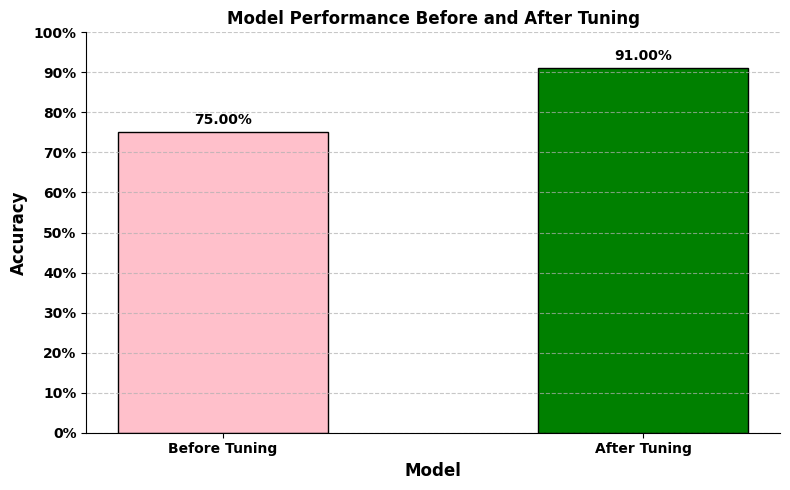

In [78]:
accuracies = {
    'Before Tuning': 0.75,
    'After Tuning': 0.91
}

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(accuracies.keys(), accuracies.values(), color=['pink', 'green'], edgecolor='k', width=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02, f'{height:.2%}', ha='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Before and After Tuning', fontsize=12, fontweight='bold')

ax.set_xticks(range(len(accuracies)))
ax.set_xticklabels(accuracies.keys(), fontsize=10, fontweight='bold')
ax.set_yticks([i/10.0 for i in range(0, 11)])
ax.set_yticklabels([f'{i*10}%' for i in range(0, 11)], fontsize=10, fontweight='bold')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

<div style="
    font-family: Arial, sans-serif;
    font-size: 18px;
    color: #2E86C1;
    text-align: right;
    position: absolute;
    right: 0;
    bottom: 0;
    padding: 10px;
">
    <strong>Data Scientist - Rajnish Jha</strong>
</div>
